In [4]:

"""
Created on Mon Aug  30  2022

@author:  ginestra_bianconi
"""
#Import of packages 
import pandas as pd
import math
import scipy
import scipy.stats
import numpy as np
import random
# setup plotting tools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
#from util import lexsort_rows

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import numpy as np
import networkx as nx
from scipy.sparse import csc_matrix
from pylab import rcParams


def create_B1(elist): #ASSUMES FIRST NODE IS INDEXED AS 1 EDGES ARE SORTED (n1,n2) with n1<n2
    num_edges = len(elist)
    data = [-1] * num_edges + [1] * num_edges
    row_ind = [e[0]-1 for e in elist] + [e[1]-1 for e in elist]
    col_ind = [i for i in range(len(elist))] * 2
    B1 = csc_matrix(
        (np.array(data), (np.array(row_ind), np.array(col_ind))), dtype=np.int8)
    return B1.toarray()

def create_B2(elist, tlist): #FUNCTION FROM PREVIOUS CODE BY MICHAEL: TO CITE
    if len(tlist) == 0:
        return csc_matrix([], shape=(len(elist), 0), dtype=np.int8)

    elist_dict = {tuple(sorted(j)): i for i, j in enumerate(elist)}

    data = []
    row_ind = []
    col_ind = []
    for i, t in enumerate(tlist):
        e1 = t[[0, 1]]
        e2 = t[[1, 2]]
        e3 = t[[0, 2]]

        data.append(1)
        row_ind.append(elist_dict[tuple(e1)])
        col_ind.append(i)

        data.append(1)
        row_ind.append(elist_dict[tuple(e2)])
        col_ind.append(i)

        data.append(-1)
        row_ind.append(elist_dict[tuple(e3)])
        col_ind.append(i)

    B2 = csc_matrix((np.array(data), (np.array(row_ind), np.array(
        col_ind))), shape=(len(elist), len(tlist)), dtype=np.int8)
    return B2.toarray()

def process(D,s_input,m,gamma):
    Q_op = gamma*(D.dot(D)-2*m*D+m**2*np.identity(np.shape(D)[0]))
    op = np.identity(np.shape(D)[0]) + Q_op
    return np.linalg.inv(op).dot((s_input))
    
def process_iterative(D,s_input,m,gamma,Nrun_max):
    Q_op = gamma*(D.dot(D)-2*m*D+m**2*np.identity(np.shape(D)[0]))
#    op = np.identity(np.shape(D)[0]) + Q_op
    s_estimated = s_input
    for nrun in np.linspace(1,Nrun_max,Nrun_max) :
        s_estimated = Q_op.dot(s_estimated)
    return s_estimated
    
def optimize_m(D,s_noisy,s_true,m,gamma,tol):
    epsilon=0.3
    check = False
    list_m = []
    list_error_m = []
    list_it =[]
    it = 0
    m_old =10000
    while (np.abs(m_old-m))>tol :
        m_old = m
        
        it = it +1
        s_est_m = process(D, s_noisy, m, gamma)
        m=(1-epsilon)*m_old+epsilon*((s_est_m.transpose()).dot(D)).dot(s_est_m)/(s_est_m.transpose().dot(s_est_m))
        error_m = np.linalg.norm(s_est_m - s_true,2)
        
        list_m.append(m)
        list_error_m.append(error_m)
        list_it.append(it)
        
    return list_m, list_error_m, list_it, m, s_est_m



def signal_processing(Gaussian,x_min,gamma,m_0,tol):

    alpha = 0.6
    s_1 = np.real(v[:,m_min_index[0]]) if x_min==True else np.real(v[:,m_max_index[0]]) 
    noise = np.random.normal(0,1,s_1.shape[0]) if Gaussian ==True else v_neg.dot(np.random.randn(v_neg.shape[1]))
    noise = (noise.real-s_1*((s_1.T).dot(noise.real)))
    noise = noise/np.linalg.norm(noise)


    s_noisy = s_1 + (1-alpha)**0.5*noise
    s_true = s_1
    
    list_m, list_error_m, list_it, m, s_est_m = optimize_m(D,s_noisy,s_true,m_0,gamma,tol)
    return list_m, list_error_m, list_it, m, s_est_m    


In [5]:
df = pd.read_csv("Padgett-Florentine-Families_multiplex.edges", sep=" ", header=None, 
                 names=["layerID", "node1", "node2","weight"])

b1= df[df['layerID'] == 1]
edge_list1 =b1[['node1', 'node2']].copy()

G = nx.Graph()
G.add_edges_from(edge_list1.values)
G.nodes()
G = nx.convert_node_labels_to_integers(G,1)
edge_list = list(G.edges())

N=G.number_of_nodes()
L = len(edge_list)
T = 0

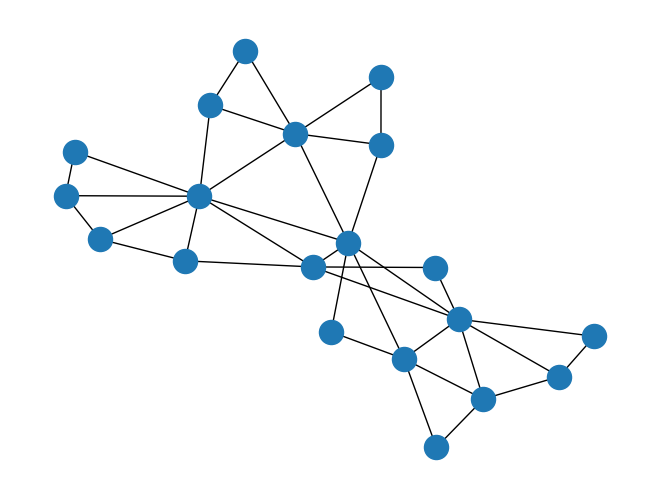

In [7]:
edge_list = pd.read_csv("NGF_edgelist.txt", sep=",", header=None, names=["node1", "node2"])

dft = pd.read_csv("NGF_triangles_d2.txt", sep=",", header=None, 
                 names=["node1", "node2","node3"])

list_triangles =np.array(list(dft.values))

G = nx.Graph()
G.add_edges_from(edge_list.values)
G.nodes()
#G = nx.convert_node_labels_to_integers(G,1)
#edge_list = list(G.edges())

N=G.number_of_nodes()
L = len(edge_list)
edge_list = edge_list.values
pos=nx.spring_layout(G,iterations=100)
nx.draw(G,pos)
triangle_list = np.array([sorted(j) for j in list_triangles])
T=len(triangle_list)

In [8]:
B1 = create_B1(edge_list)

D1 = np.block([[np.zeros((N,N)),B1],
                [B1.transpose(),np.zeros((L,L))]])

if (T>0):
    B2 = create_B2(edge_list, triangle_list)
    D2 = np.block([[np.zeros((L,L)),B2],[B2.transpose(),np.zeros((T,T))]])
    gamma2 = np.block([[-np.eye(L),np.zeros((L,T))],[np.zeros((T,L)),np.eye(T)]])

In [9]:
#select D_one=True for D1 (nodes and links signal processing) and D_one=False for D2 (links and triangles signal processing)
D_one=[True, False][0]
D = D1 if D_one==True else D2 
w, v = np.linalg.eig(D)

In [10]:
w_real = np.real_if_close(w)
w_min = w_real[(w_real > 0) & (~np.isclose(w_real, 0))].min()
m_min_index = np.where(w_real == w_min)[0]
w_real[m_min_index]
w_max = w_real[(w_real > 0) & (~np.isclose(w_real, 0))].max()
m_max_index = np.where(w_real == w_max)[0]
w_real[m_max_index]
mask_neg_and_nonzero = (w_real < 0) & (~np.isclose(w_real, 0))
v_neg = v[:, mask_neg_and_nonzero

# Fin qui ok!

In [11]:
def visualization_plot(i1,Gaussian,x_min,lab,ax=None):
#x_min=True selects true signal aligned to the eigenvector associated to the smallest positive eigenvalue 
#x_min= False selects true signal aligned to the eigenvector associated to the largest positive eigenvalue 
#Gaussian=True selects gaussian noise Gaussian=False select noise having only contribution coming from vector with negative chiarality

    if ax is None:
        fig, axis = plt.subplots(nrows=1, ncols=1)
    else:
        axis1 = ax[0][i1]
        axis2 = ax[1][i1]
    
    
    gamma = 10.
    #list_error_m, list_error, list_mass   = signal_processing(antialigned,x_min,gamma)
    
    m_0 = 1.4  if x_min==True else 4.0
    tol = 0.001
    m_index = m_max_index[0] if x_min==False else m_min_index[0]
    list_m, list_error_m, list_it, m, s_est_m = signal_processing(Gaussian,x_min,gamma,m_0,tol)

    if lab == True:
        axis1.plot(list_it,list_m,label='inferred m') 
        axis1.plot(list_it,w_real[m_index]*np.ones(np.shape(list_it)[0]),label='true m')
        axis2.plot(list_it,list_error_m)
        

    else:
        axis1.plot(list_it,list_m) 
        axis1.plot(list_it,w_real[m_index]*np.ones(np.shape(list_it)[0]))
        axis2.plot(list_it,list_error_m)
        
        
    axis1.legend(frameon=False)
    axis1.set_xlabel('$time$')
    axis1.set_ylabel('$m$')
    
    axis2.legend(frameon=False)
    axis2.set_xlabel('$time$')
    axis2.set_ylabel('$\Delta s(m)/\Delta s(0)$')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


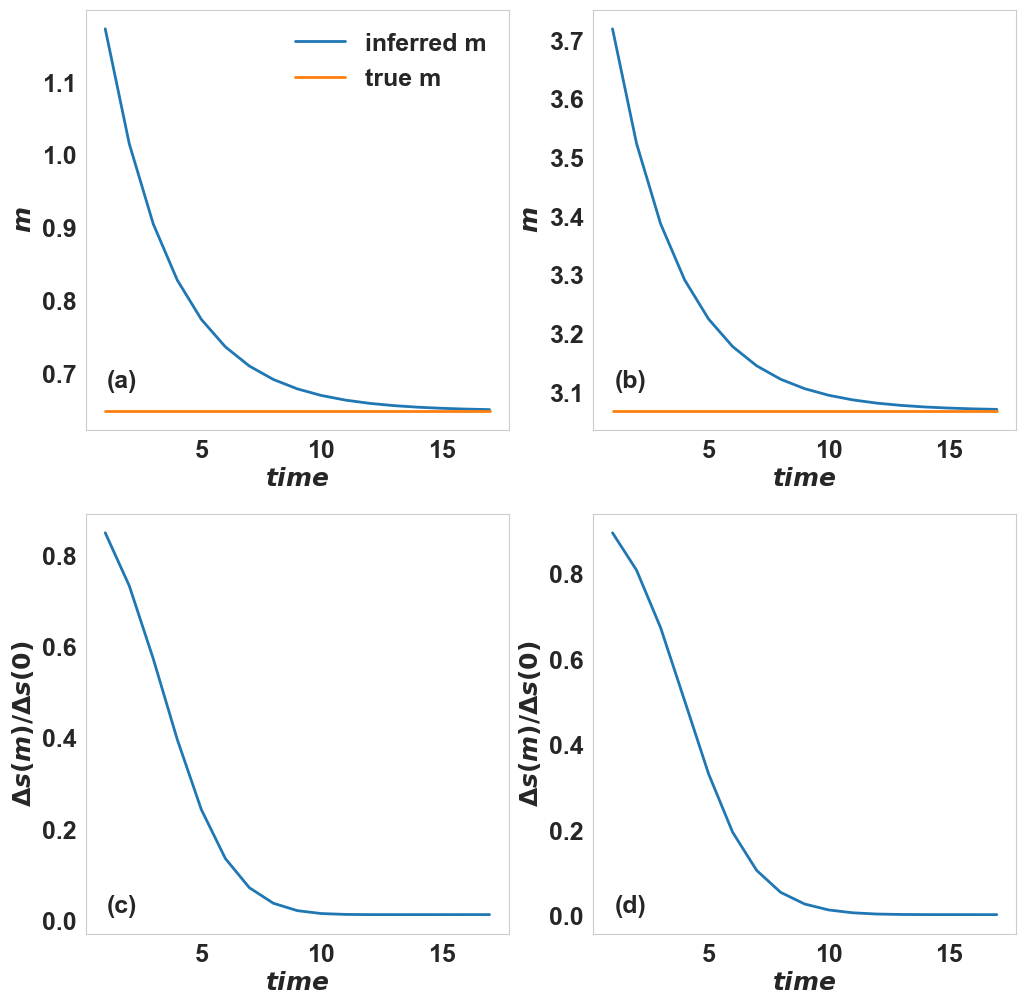

In [12]:
rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

visualization_plot(0,False,True,True, ax=axs)
visualization_plot(1,False,False,False, ax=axs)

plt.annotate('(a)', xy=(-1.15, 1.30), xycoords='axes fraction',size=18)
plt.annotate('(b)', xy=(0.05, 1.30), xycoords='axes fraction',size=18)
plt.annotate('(c)', xy=(-1.15, 0.05), xycoords='axes fraction',size=18)
plt.annotate('(d)', xy=(0.05, 0.05), xycoords='axes fraction',size=18)
plt.show()

fig.savefig('Florentine_Families_mass.pdf') 